In [174]:
from collections import Counter


import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm # progress apply :)
tqdm.pandas()

from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')


%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
new_articles=pd.read_excel("2025-04-26 Manual Annotation results_Inclusion.xlsx")[["ID","text"]]
with open('2025-06-06_final_data.txt') as txt:
    dataID=txt.read().split(",")
    


df=pd.read_json("2025-06-06 PDF import filtered.json")

# check if all data is importet
df=df[df.index.isin(dataID)]
t=df.index.to_list()
set(dataID)-set(t)
print(df.shape, len(dataID))


(1018, 6) 1027


In [176]:
df.loc[['Nature507','Nature507b','Nature454','Nature454b']].text

Nature507     Dance retraction. An eight-year-old Nature pap...
Nature507b    GM study retracted. Bowing to scientists nearu...
Nature454     Study retracted. A landmark paper proposing a ...
Nature454b    types of mature cells. In 2011,he stunned the ...
Name: text, dtype: object

In [177]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    results=[]
    for token in doc:
        # Check if the token is a noun
        if token.pos_ == "NOUN" or token.pos_ =="ADJ"or token.pos_ =="PROPN":

            if len(token.text)>2:
                results.append(token.lemma_)
    
    return results


# Assuming df is a pandas DataFrame and 'text' is a column in it
df["noun_adj"] = df["text"].progress_apply(extract_nouns)

100%|███████████████████████████████████████| 1018/1018 [00:25<00:00, 39.41it/s]


In [178]:
df["noun_adj"].explode().value_counts()[20:40]

noun_adj
work           660
editor         660
such           655
more           622
many           580
article        558
Nature         548
publication    512
time           477
university     449
group          448
review         442
people         421
new            417
report         405
finding        397
last           376
team           373
experiment     371
problem        360
Name: count, dtype: int64

In [179]:
noun_adj_propn=df["noun_adj"].explode().drop_duplicates().to_list()
len(noun_adj_propn)

31050

# Academic Fields

In [181]:
#https://github.com/kyletscheer/academic-disciplines

df_academic_fields=pd.read_excel("2024-11-14 Academic Disciplines List.xlsx",index_col="ID")
print(df_academic_fields.Field.unique())

print(df_academic_fields.Domain.unique())
df_academic_fields.columns

[nan 'Performing Arts' 'Visual Arts' 'History' 'Languages and Literature'
 'Law' 'Philosophy' 'Anthropology' 'Economics' 'Geography'
 'Political Science' 'Psychology' 'Sociology' 'Social Work' 'Biology'
 'Chemistry' 'Earth Science' 'Space Sciences' 'Physics' 'Computer Science'
 'Mathematics' 'Business' 'Engineering and Technology'
 'Medicine and Health']
['Humanities' 'Social Sciences' 'Natural Sciences' 'Formal Sciences'
 'Applied Sciences']


Index(['Domain', 'Field', 'Category', 'Subcategory', 'Subject', 'Discipline'], dtype='object')

In [182]:
df_academic_fields['combined']= df_academic_fields[["Field",'Category', 'Subcategory', 'Subject', 'Discipline']].values.tolist()
df_academic_fields=pd.DataFrame(df_academic_fields.groupby("Field")["combined"].agg(lambda x: list(set(sum(x, [])))))

In [183]:
import regex as re
df_academic_fields['combined']=df_academic_fields['combined'].apply(lambda x: [re.sub(r' ?\((.*?)\) ?',"",i) for i in x if isinstance(i,str)])
df_academic_fields['combined']=df_academic_fields['combined'].apply(lambda x: [i for i in x if re.search(" of ",i)==None]) # remove philosophy of AI and taht shit
df_academic_fields['combined']

Field
Anthropology                  [Biological anthropology, Social anthropology,...
Biology                       [Molecular genetics, Cetology, Mycology, Micro...
Business                      [Finance, Business management, Business, Marke...
Chemistry                     [Chemistry, Molecular biology, Surface chemist...
Computer Science              [Relational database, Automata theory , Finite...
Earth Science                 [Edaphology, Paleontology, Glaciology, Geology...
Economics                     [Environmental economics, Econometrics, Applie...
Engineering and Technology    [Ceramic engineering, Instructional simulation...
Geography                     [Time geography, Emergency management, Oceanog...
History                       [Modern history, Indian history , Ancient Gree...
Languages and Literature      [American literature, Creative writing, Ancien...
Law                           [Legal management, Commercial law, Public inte...
Mathematics                   [Alg

In [184]:
all_jobs=", ".join(set(df_academic_fields['combined'].explode().dropna()))
all_jobs_propn=extract_nouns(all_jobs)
all_jobs_propn_reduced=set(all_jobs_propn) & set(noun_adj_propn)

len(all_jobs), len(all_jobs_propn_reduced)

(22024, 548)

In [185]:
len(all_jobs_propn_reduced)
df_academic_fields['combined']["Anthropology"]

extract_nouns(" ".join(df_academic_fields['combined']["Anthropology"]))

['biological',
 'anthropology',
 'Social',
 'anthropology',
 'Archaeology',
 'Cultural',
 'anthropology',
 'Anthropology',
 'Linguistic',
 'anthropology']

In [186]:
import regex as re
pattern=re.compile("|".join(all_jobs_propn_reduced))

#exclude_pattern=re.compile("|".join(["real","^sciences?","^theory","^law","^studies","^time","methods","outline","scientific","free","world","age","non"]),re.IGNORECASE)

def check_if_relevant(text):
    if isinstance(text,list):
        text=[i for i in text if isinstance(i, str)]
        # If none of the pattern lemmata is in the string, then the job is not relevant.
        
        text = [job for job in text if re.search(pattern, job)]
        text = [re.sub(" or|,"," and",job) for job in text]
        text2=([job.split(" and ") for job in text  if " and "  in job ])
        text2=[j for i in text2 for j in i]

        text.extend(text2)
        #text=[i for i in text if re.search(exclude_pattern,i)==None]
        text=list(set(text))
    return text

df_academic_fields['combined_reduced']=df_academic_fields['combined'].apply(check_if_relevant)

In [187]:
df_academic_fields['combined_reduced']

Field
Anthropology                  [Biological anthropology, Social anthropology,...
Biology                       [Forensic entomology, Histopathology, Molecula...
Business                      [Finance, Business management, Operations mana...
Chemistry                     [Chemistry, Molecular biology, Surface chemist...
Computer Science              [Relational database, Finite element analysis,...
Earth Science                 [Paleontology, Hydrology / Limnology / Hydroge...
Economics                     [Environmental economics, Financial economics,...
Engineering and Technology    [Polymer science, Ceramic engineering, Instruc...
Geography                     [Time geography, Emergency management, Oceanog...
History                       [Modern history, Chinese history, Indian histo...
Languages and Literature      [American literature, Ancient literature, Afri...
Law                           [Legal management, Commercial law, Public inte...
Mathematics                   [Alg

In [188]:
job_ext_dict={
    "y":["ists?","ers?","ians?", "ysts?","y"],
    "chemistry":["Chemists?"],
    "law":["legal scholars?","legal reseachers?","law scholars?"],
    "ics":["ists?","isists?","icians?","ics"], ## but lots of ethics
    " studies": [" scholars?", " researchers?"," scientists?"," studies"],
    " sciences": [" scholars?"," researchers?"," scientists?"," sciences"],
    "ine":  ["ists?","ine"],
    "ion":["ists?","ors?","ion"],
    "sition":["nists?","ners?","sition"],
    "design":["designers?","design researchers?","design"],
    "sis":["ysts?","ists?","sis researchers?","sis scientists?"],
    "engineering":["engineers?","engineering"],
    "programming":["programmers?"]}


def add_jobs(job_list):
    job_list=list(set(job_list))
    new_list=[]
    all_keys=re.compile("|".join([k+"$" for k in job_ext_dict.keys()]),flags=re.IGNORECASE)

    for job in job_list:
        important_key=re.search(all_keys,job)
        if important_key!=None:

            important_key=important_key.group().lower()
            #print(important_key)
            v=job_ext_dict[important_key]
            #print(re.match(all_keys,job))
            for v_item in v:
                #print(job, v_item,important_key)
                new_job=re.sub(important_key+"$", v_item, job, flags=re.IGNORECASE)
               # print(job,new_job)
                new_list.append(new_job)
        else:
            for i in ["students?","scholars?","researchers?","scientists?"]:
                new_job=f"{job} {i}"
                new_list.append(new_job)

        

    #job_list+=new_list
    #new_list+=job_list
    return new_list

df_academic_fields["combined_extended"]=df_academic_fields["combined_reduced"].apply(add_jobs)


In [189]:

all_jobs=df_academic_fields["combined_extended"].explode().dropna().drop_duplicates()
all_jobs_tuple_list = list(zip(all_jobs.index, all_jobs.values))

print(len(all_jobs.to_list()))
#all_jobs["Physics"].to_list()

3701


In [190]:
import regex as re

all_jobs_ext_regex= re.compile(r"\b(" + "|".join(all_jobs) + r")\b"+r"{i<=2:\s}(?b)(?e)", re.IGNORECASE)

def keyword_check(text, re_pattern):
    if isinstance(text,str):
        matches=re.findall(re_pattern,text)
        matches=[i for i in matches if i]
        return matches

df["all_jobs"]=df["text"].progress_apply(keyword_check, re_pattern=all_jobs_ext_regex)

#df["all_jobs"]=df["text"].progress_apply(keyword_check, re_pattern=all_jobs_regex)

100%|███████████████████████████████████████| 1018/1018 [00:14<00:00, 70.93it/s]


In [191]:
# Most common Job names in the corpus
df["all_jobs"].explode().str.title().value_counts()[:20]

all_jobs
Technology               175
Medicine                 136
Biology                  114
Biologist                 79
Physics                   71
Engineering               32
Chemist                   31
Biologists                30
Evolution                 27
Surgery                   24
Social Psychologist       20
Physician                 18
Microbiologist            18
Physicians                18
Developmental Biology     17
Bioethics                 17
Chemists                  16
Epidemiologist            15
Pathology                 13
Oncology                  13
Name: count, dtype: int64

In [192]:
## fixed AMBIGUITY: Consider that the jobs can fit into multiple disciplines: if more than one discipline fits to the job --> ignore!

def lookup(s, lookups):
    matched_patterns = []  # Initialize an empty list to collect matches
    for pattern, value in lookups:
        if re.search(value, s, re.IGNORECASE):
            matched_patterns.append(pattern) # Append the pattern to the list if there's a match
    if len(matched_patterns)==1:
        return matched_patterns[0]  # Return the list of matched patterns
    else:
        return None

df["fields"] = df["all_jobs"].progress_apply(lambda x: [lookup(job, all_jobs_tuple_list) for job in x])


100%|███████████████████████████████████████| 1018/1018 [02:46<00:00,  6.10it/s]


<Axes: title={'center': 'academic fields (multiple per paper)'}, ylabel='count'>

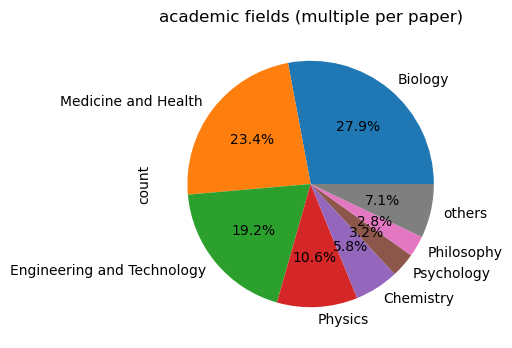

In [193]:
Disciplines2=df["fields"] .explode().value_counts()

top_x=7
top5=Disciplines2[:top_x]
top5["others"]=Disciplines2[top_x:].sum()
top5.plot.pie(figsize=(4,4), title="academic fields (multiple per paper)", autopct='%1.1f%%')

In [194]:

# Function to find the most common fields per paper
def most_common(fields):
    if not fields or all(f is None for f in fields):  # Handle empty or None lists
        return []
    
    # Count occurrences and find the max count
    counts = pd.Series(fields).value_counts()
    max_count = counts.max()
    
    # Return all fields with the max count
    return counts[counts == max_count].index.tolist()

# Apply the function to the 'fields' column
df['most_common_fields'] = df["fields"].apply(most_common)

In [195]:
df['most_common_fields']

Science113     [Physics, Chemistry]
Science116                       []
Science119                       []
Science149                [Biology]
Science159                       []
                      ...          
Nature1223                       []
Nature1358    [Medicine and Health]
Nature293                        []
Nature507b                       []
Nature454b                       []
Name: most_common_fields, Length: 1018, dtype: object

<Axes: title={'center': 'academic fields (one per paper)'}, ylabel='count'>

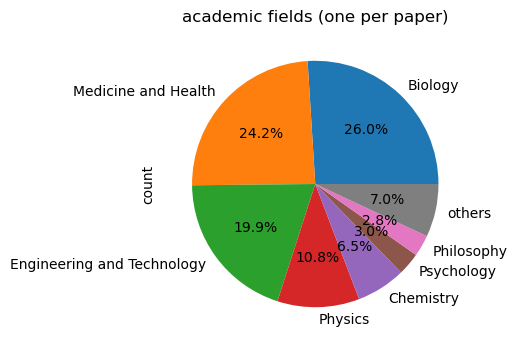

In [196]:
Disciplines3=df['most_common_fields'].explode().value_counts()


top_x=7
top5=Disciplines3[:top_x]
top5["others"]=Disciplines3[top_x:].sum()
top5.plot.pie(figsize=(4,4), title="academic fields (one per paper)", autopct='%1.1f%%')

In [197]:
df[["fields","all_jobs",'most_common_fields']].head()

,fields,all_jobs,most_common_fields
Science113,"[Physics, Chemistry]","[physician, pharmacologist]","[Physics, Chemistry]"
Science116,[],[],[]
Science119,[None],[economist],[]
Science149,"[Biology, Physics, Biology, Engineering and Te...","[biologists, physics, biologist, Technology, b...",[Biology]
Science159,[],[],[]


In [198]:
df_academic_fields["combined_extended_regex"]=df_academic_fields["combined_extended"].apply(lambda x:"|".join(x)).str.replace("||","|")

#academic_fields_dict_regex={k:re.compile("(" +v + ")" +r"{i<=2:\s}(?b)(?e)", re.IGNORECASE) for k,v in df_academic_fields["combined_extended_regex"].items()}
academic_fields_dict_regex={k:re.compile("\b"+v+"\b", re.IGNORECASE) for k,v in df_academic_fields["combined_extended_regex"].items()}

academic_fields_dict_regex['Physics']

regex.Regex('\x08and optical physists?|and optical physisists?|and optical physicians?|and optical physics|Condensed matter physists?|Condensed matter physisists?|Condensed matter physicians?|Condensed matter physics|Fluid dynamists?|Fluid dynamisists?|Fluid dynamicians?|Fluid dynamics|Theoretical physists?|Theoretical physisists?|Theoretical physicians?|Theoretical physics|Statistical mechanists?|Statistical mechanisists?|Statistical mechanicians?|Statistical mechanics|Atomic and molecular and and optical physists?|Atomic and molecular and and optical physisists?|Atomic and molecular and and optical physicians?|Atomic and molecular and and optical physics|Experimental physists?|Experimental physisists?|Experimental physicians?|Experimental physics|Atomic students?|Atomic scholars?|Atomic researchers?|Atomic scientists?|Astrophysists?|Astrophysisists?|Astrophysicians?|Astrophysics|Physists?|Physisists?|Physicians?|Physics|Plasma physists?|Plasma physisists?|Plasma physicians?|Plasma ph

In [199]:
#fields_regex={k: re.compile("(" + "|".join(v) + ")" +r"{i<=2:\s}(?b)(?e)", re.IGNORECASE) for k, v in academic_fields.items()}
#fields_regex={k: re.compile("(" + "|".join(v) + ")" +r"{i<=2:\s}(?b)(?e)", re.IGNORECASE) for k, v in fields_dict.items()}


def keyword_check(text, re_pattern):
    if isinstance(text,str):
        matches=re.findall(re_pattern,text)

        return len(matches)

for k, v in academic_fields_dict_regex.items():
    print(k)
    df[k]=df["text"].progress_apply(keyword_check, re_pattern=v)

Anthropology


100%|█████████████████████████████████████| 1018/1018 [00:00<00:00, 7073.42it/s]


Biology


100%|██████████████████████████████████████| 1018/1018 [00:02<00:00, 347.70it/s]


Business


100%|████████████████████████████████████| 1018/1018 [00:00<00:00, 16445.72it/s]


Chemistry


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 996.03it/s]


Computer Science


100%|██████████████████████████████████████| 1018/1018 [00:04<00:00, 212.11it/s]


Earth Science


100%|█████████████████████████████████████| 1018/1018 [00:00<00:00, 2337.18it/s]


Economics


100%|██████████████████████████████████████| 1018/1018 [00:02<00:00, 408.01it/s]


Engineering and Technology


100%|██████████████████████████████████████| 1018/1018 [00:06<00:00, 166.97it/s]


Geography


100%|█████████████████████████████████████| 1018/1018 [00:01<00:00, 1013.21it/s]


History


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 558.14it/s]


Languages and Literature


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 909.12it/s]


Law


100%|█████████████████████████████████████| 1018/1018 [00:00<00:00, 1024.82it/s]


Mathematics


100%|██████████████████████████████████████| 1018/1018 [00:05<00:00, 175.47it/s]


Medicine and Health


100%|██████████████████████████████████████| 1018/1018 [00:03<00:00, 259.52it/s]


Performing Arts


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 852.00it/s]


Philosophy


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 639.26it/s]


Physics


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 859.16it/s]


Political Science


100%|█████████████████████████████████████| 1018/1018 [00:00<00:00, 2467.45it/s]


Psychology


100%|██████████████████████████████████████| 1018/1018 [00:03<00:00, 269.04it/s]


Social Work


100%|█████████████████████████████████████| 1018/1018 [00:00<00:00, 7649.70it/s]


Sociology


100%|██████████████████████████████████████| 1018/1018 [00:03<00:00, 294.50it/s]


Space Sciences


100%|██████████████████████████████████████| 1018/1018 [00:01<00:00, 827.79it/s]


Visual Arts


100%|█████████████████████████████████████| 1018/1018 [00:00<00:00, 2271.94it/s]


In [200]:
Disciplines=df[df_academic_fields.index]
Disciplines

,Anthropology,Biology,Business,Chemistry,Computer Science,Earth Science,Economics,Engineering and Technology,Geography,History,...,Medicine and Health,Performing Arts,Philosophy,Physics,Political Science,Psychology,Social Work,Sociology,Space Sciences,Visual Arts
Science113,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
Science116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Science119,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Science149,0,4,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
Science159,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nature1223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Nature1358,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Nature293,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Nature507b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
more_than_one_non_zero= Disciplines[(Disciplines != 0).sum(axis=1) > 1]
more_than_one_non_zero

## Only 323 papers mention disciplines

,Anthropology,Biology,Business,Chemistry,Computer Science,Earth Science,Economics,Engineering and Technology,Geography,History,...,Medicine and Health,Performing Arts,Philosophy,Physics,Political Science,Psychology,Social Work,Sociology,Space Sciences,Visual Arts
Science113,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
Science149,0,4,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
Science16,0,5,0,2,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
Science192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
Science248,0,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nature976,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0
Nature979,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
Nature983,0,2,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
Nature985,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


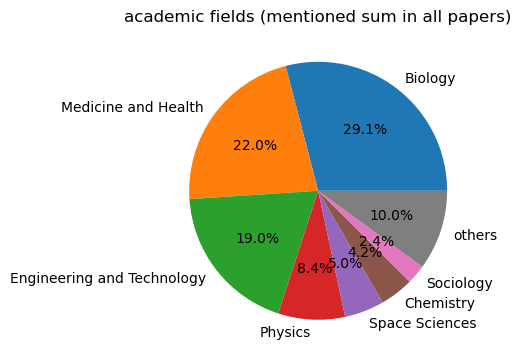

In [202]:
top_x=7

top5=Disciplines.sum().sort_values(ascending=False)[:top_x]
top5["others"]=Disciplines.sum().sort_values(ascending=False)[top_x:].sum()
top5.plot.pie(figsize=(5,5), title="academic fields (mentioned sum in all papers)", autopct='%1.1f%%')



plt.tight_layout()
plt.savefig(today+" disciplines pie.jpg",dpi=300)

# <5% attributed to others

In [203]:
Disciplines.sum().sort_values(ascending=False)

Biology                       521
Medicine and Health           394
Engineering and Technology    340
Physics                       150
Space Sciences                 89
Chemistry                      76
Sociology                      43
Psychology                     38
Philosophy                     33
Geography                      31
Earth Science                  21
Economics                      19
Anthropology                   17
Computer Science                7
Mathematics                     6
Political Science               4
Languages and Literature        2
History                         2
Social Work                     0
Law                             0
Performing Arts                 0
Business                        0
Visual Arts                     0
dtype: int64

<Axes: title={'center': 'academic fields (only max one per paper)'}, ylabel='count'>

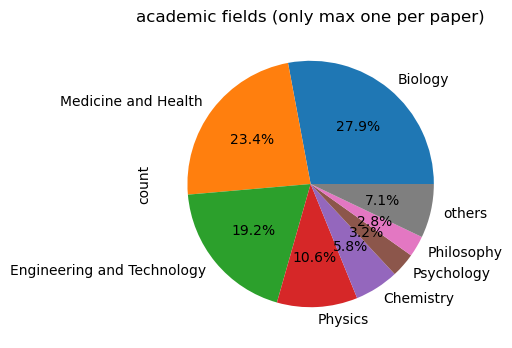

In [204]:

# look for the max values in each row
mxs = Disciplines.eq(Disciplines.max(axis=1), axis=0)
mxs_1=mxs[mxs.sum(axis=1)==1]

# join the column names of the max values of each row into a single string
labels = mxs_1.dot(mxs.columns + ', ').str.rstrip(', ')
labels=labels.str.split(", ")
labels=labels[labels.str.len()<7]



top_x=7
top5=Disciplines2[:top_x]
top5["others"]=Disciplines2[top_x:].sum()
top5.plot.pie(figsize=(4,4), title="academic fields (only max one per paper)", autopct='%1.1f%%')

# Country

In [206]:
## Import from her or use existing df

# ensure that lists are read as list and not as strings
#from ast import literal_eval
#columns_to_convert=["texts","labels","retraction_counts","has_retraction","has_retraction_label"]
#converters = {col: literal_eval for col in columns_to_convert}

#df=pd.read_csv("2025-02-23 PDF_import (docling - complete).csv",index_col=0, converters=converters)


In [207]:
df.labels.explode().value_counts()

labels
text                   39859
section_header          9052
list_item               2525
caption                  755
page_header              228
checkbox_unselected       56
footnote                  47
paragraph                 28
checkbox_selected          4
formula                    1
code                       1
Name: count, dtype: int64

In [208]:
# filter text labels:
# 1. Filter by a list of allowed lables.
# 2. Filter by the method "till next section header"
#allowed_lablels=["text","section_header","caption","paragraph","page_header","section_header"]

#df=pd.DataFrame.from_records(df.apply(labelfilter.filter_texts_by_labels,allowed_labels=allowed_lablels,axis=1))
#neighboring_texts = df.apply(lambda row: labelfilter.get_neighboring_texts(row['texts'], row['retraction_counts']), axis=1)
#df["text"]=neighboring_texts.apply(lambda x: " ".join(x))


In [209]:
demmonym=pd.read_excel("2024-11-14 demonym.xlsx")
# List from: https://www.thoughtco.com/the-names-of-nationalities-4088817

print("fix Demonyms: \n", demmonym.tail(3))
demmonym=dict(zip(demmonym.Demonym,demmonym.Country))
demmonym={k.replace(" or ","|").replace(", ","|").replace("/woman","").replace(" (collective)",""):v.split("/",1)[0] for k,v in demmonym.items()}

demmonym={f"({k})(s|ese|ish)?":v for k,v in demmonym.items()}

df["text"]=df.text.replace(demmonym,regex=True)


# tested with "American" & Americans --> "United States of America"

fix Demonyms: 
       Country             Demonym
190     Yemen  Yemeni or Yemenite
191    Zambia             Zambian
192  Zimbabwe          Zimbabwean


In [210]:
#!pip install geonamescache
#!pip install pycountry

import geonamescache
import pycountry

# Load the geonamescache data
gc = geonamescache.GeonamesCache()
cities_data = gc.get_cities()

# Minimal city population: 100.000

# Create a dictionary to map city names to countries
city_country_map = {city['name']: pycountry.countries.get(alpha_2=city['countrycode']).name for city in cities_data.values() 
                    if pycountry.countries.get(alpha_2=city['countrycode']) and city['population']>100000}

city_country_map2 = {}
city_city_map = {}
for city in cities_data.values():
    if city['population']>100000:
        for alt_name in city['alternatenames']:
            alt_name=alt_name.replace("The","")
            if len(alt_name)>3 and alt_name[0].isupper():
                if pycountry.countries.get(alpha_2=city['countrycode']):
                    city_city_map[alt_name]=city["name"]
                    city_country_map2[alt_name] = pycountry.countries.get(alpha_2=city['countrycode']).name

city_country_map.update(city_country_map2)


#refinements:

# Dr Baltimore --> remove Baltimore
# Human & Genes are not cities in this context
# Van --> most likely some Dutch Name artifact (Van Andel & Van Parijs) and not the Turkish City

drop_keys=["Human", "Genes", "Baltimore", "Van"]
for key in drop_keys:
    city_country_map.pop(key, None)
    city_country_map2.pop(key, None)
    city_city_map.pop(key, None)

In [211]:
from collections import defaultdict

# Alternative to keep all keys
Alternative_Names_list = defaultdict(list)

for k, v in city_city_map.items():
    Alternative_Names_list[v].append(k)
    

In [212]:
import regex as re
countries=list(set(city_country_map.values()))
cities=list(set(city_country_map.keys()))


# Prepare the regex pattern from the city names

city_names_pattern = r"\b(" + '|'.join(re.escape(city) for city in cities) + r")\b"
country_names_pattern = r"("+'|'.join(re.escape(country) for country in countries)+")" 

city_pattern = re.compile(city_names_pattern)
country_pattern = re.compile(country_names_pattern)

import regex as re

def keyword_check(text, re_pattern):
    if isinstance(text,str):
        matches=re.findall(re_pattern,text)
        return matches
    
df['contains_city']=df.text.progress_apply(keyword_check, re_pattern=city_names_pattern)
df['contains_country']=df.text.progress_apply(keyword_check, re_pattern=country_names_pattern)




100%|████████████████████████████████████| 1018/1018 [00:00<00:00, 11560.44it/s]


In [213]:
df['contains_country']

Science113                                       []
Science116                           [China, China]
Science119                           [South Africa]
Science149                               [Bulgaria]
Science159    [United States, United Kingdom, Chad]
                              ...                  
Nature1223                           [Japan, Japan]
Nature1358                                       []
Nature293                            [China, China]
Nature507b                                       []
Nature454b                                       []
Name: contains_country, Length: 1018, dtype: object

In [214]:
from collections import Counter
df['city']=df['contains_city'].apply(lambda x: [city_city_map[i] if i in city_city_map else i for i in x ])
df['country_from_city']=df['contains_city'].apply(lambda x: [city_country_map[i] if i in city_country_map else i for i in x ])
df["country_plus_city"]=df["country_from_city"]+df["contains_country"]
df['Most Common country_city'] = df["country_plus_city"].apply(lambda x: Counter(x).most_common()[0][0] if len(x)>0 else None)
df['Most Common country_no_city'] = df['contains_country'].apply(lambda x: Counter(x).most_common()[0][0] if len(x)>0 else None)

df[['Most Common country_city','Most Common country_no_city']]
df['Most Common country_city'].value_counts()


Most Common country_city
United States     312
China              68
Japan              67
United Kingdom     56
Germany            41
                 ... 
Sierra Leone        1
Turkmenistan        1
Bulgaria            1
Congo               1
Croatia             1
Name: count, Length: 64, dtype: int64

KeyError: 'Most Common country'

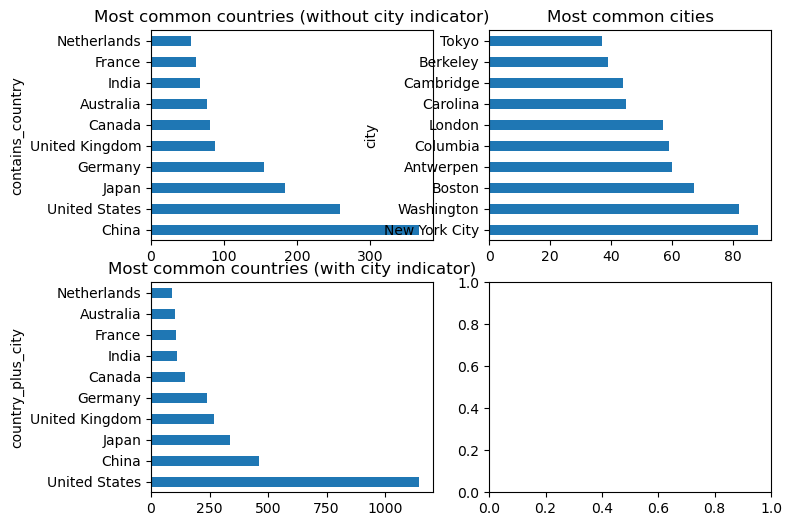

In [215]:

import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# Plot 1: Most common countries - without city indicator
df['contains_country'].explode().dropna().value_counts()[:10].plot.barh(
    ax=axs[0, 0], title="Most common countries (without city indicator)"
)

# Plot 2: Most common cities
df['city'].explode().value_counts()[:10].plot.barh(
    ax=axs[0, 1], title="Most common cities"
)

# Plot 3: Most common countries, including city indicator
df["country_plus_city"].explode().value_counts()[:10].plot.barh(
    ax=axs[1, 0], title="Most common countries (with city indicator)"
)

# Plot 4: Most common countries, only one country per paper
df['Most Common country'].value_counts()[:10].plot.barh(
    ax=axs[1, 1], title="Most common countries (one country per article)"
)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
df['Most Common country_no_city'].value_counts()[:10]

In [ ]:
df["name"]=df.index

In [ ]:
relevat_rows=["contains_country","country_plus_city","Most Common country","Most Common country_no_city","all_jobs", 'fields','most_common_fields',"name"]
df[relevat_rows].to_csv("2025-06-07 Country_fields results.csv")
df[relevat_rows].to_json("2025-06-07 Country_fields results.json")

In [ ]:
df[relevat_rows]